# Supervised Model for unclassifed requests

There were about 40% of prechats requests not able to identify intents clearly by unsupervised  Kmean model(s). 
This supervised model used to predict the intents for requests which the Kmean models (both L1 and L2) not able to predict clearly. This model using training data which generated by combining output of Kmean model and  bssiness feedback

In [1]:
import pandas as pd
df = pd.read_csv('prechat_bigcluter_gt.csv')
df.head()

,topicid,topicname,prechat
0,2039,LN - Not working- No info provided,lotus notes
1,2034,LN - new laptop (thinkpad) configuration,hello problems with lotus notes after i trans...
2,2061,LN - Server Connection issues,unable to log into lotus notes due to server e...
3,2026,LN - Install issues,hello ibm notes need to install on linux
4,2034,LN - new laptop (thinkpad) configuration,agent amy ensure to close the session without ...


In [6]:
from io import StringIO
col = ['topicname', 'prechat','topicid']
df = df[col]
df = df[pd.notnull(df['prechat'])]
topicid_df = df[['topicname', 'topicid']].drop_duplicates().sort_values('topicid')
topicid_to_id = dict(topicid_df.values)
id_to_category = dict(topicid_df[['topicid', 'topicname']].values)
df.head(15)

,topicname,prechat,topicid
0,LN - Not working- No info provided,lotus notes,2039
1,LN - new laptop (thinkpad) configuration,hello problems with lotus notes after i trans...,2034
2,LN - Server Connection issues,unable to log into lotus notes due to server e...,2061
3,LN - Install issues,hello ibm notes need to install on linux,2026
4,LN - new laptop (thinkpad) configuration,agent amy ensure to close the session without ...,2034
5,LN - Configuratiuon issues,hineed to configure notes,2010
6,LN - Reinstall,hello my lotus notes had to be reinstalled but...,2054
7,LN - Configuratiuon issues,need an incident for notes configuration and o...,2010
8,LN - Reinstall,ibm notes has been resinstalled in my machine ...,2054
9,LN - Reconfigure,ibm notes is asking to reconfigure while using,2053


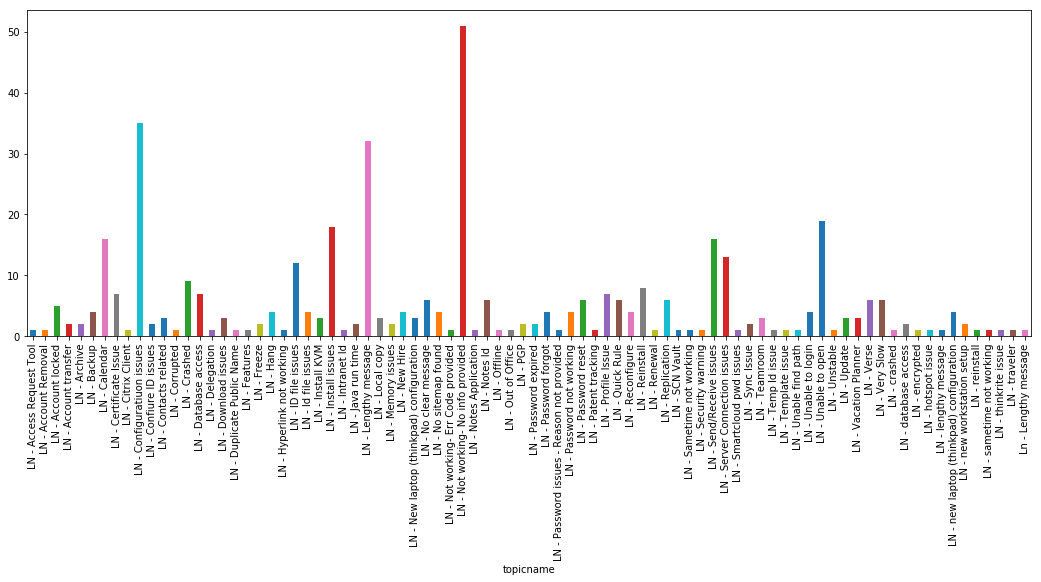

'/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

In [9]:
import matplotlib
matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,6))
df.groupby('topicname').prechat.count().plot.bar(ylim=0)
plt.show()
import matplotlib
matplotlib.matplotlib_fname()

In [34]:
import nltk
stopwords = nltk.corpus.stopwords.words('english') 
stopwords = stopwords +['ye','hello','hi','im','hii','ticket','serial','ok','lotus','lotu','pleas','wwsedhden','zzvb','contractor',
                        'would','want','like','support','regard',
                        'saumya','team','zzzn','zzz','zzl','ha','get','thi','notes','note','ibm',
                        'may','chat','help','having','have','need','wwsed','hden']

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)
features = tfidf.fit_transform(df.prechat).toarray()
labels = df.topicid
features.shape

(416, 149)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['prechat'], df['topicname'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [37]:
print(clf.predict(count_vect.transform(["hello i need to open two tickets for two new hires in order to install their lotus notes here is the list"])))

['LN - Lengthy message']


In [38]:
print(clf.predict(count_vect.transform(["lotus notes mail rule not working"])))

['LN - Not working- No info provided']


In [39]:
print(clf.predict(count_vect.transform(["configure notes kvm window  and resolve some pop ups "])))
print(clf.predict(count_vect.transform(["lotus notes needs to install port number  in kvm "])))


['LN - Configuratiuon issues']
['LN - Not working- No info provided']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3

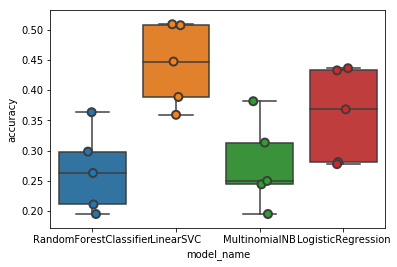

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Model accuracy comparisions

In [41]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.442437
LogisticRegression        0.359330
MultinomialNB             0.277002
RandomForestClassifier    0.266345
Name: accuracy, dtype: float64

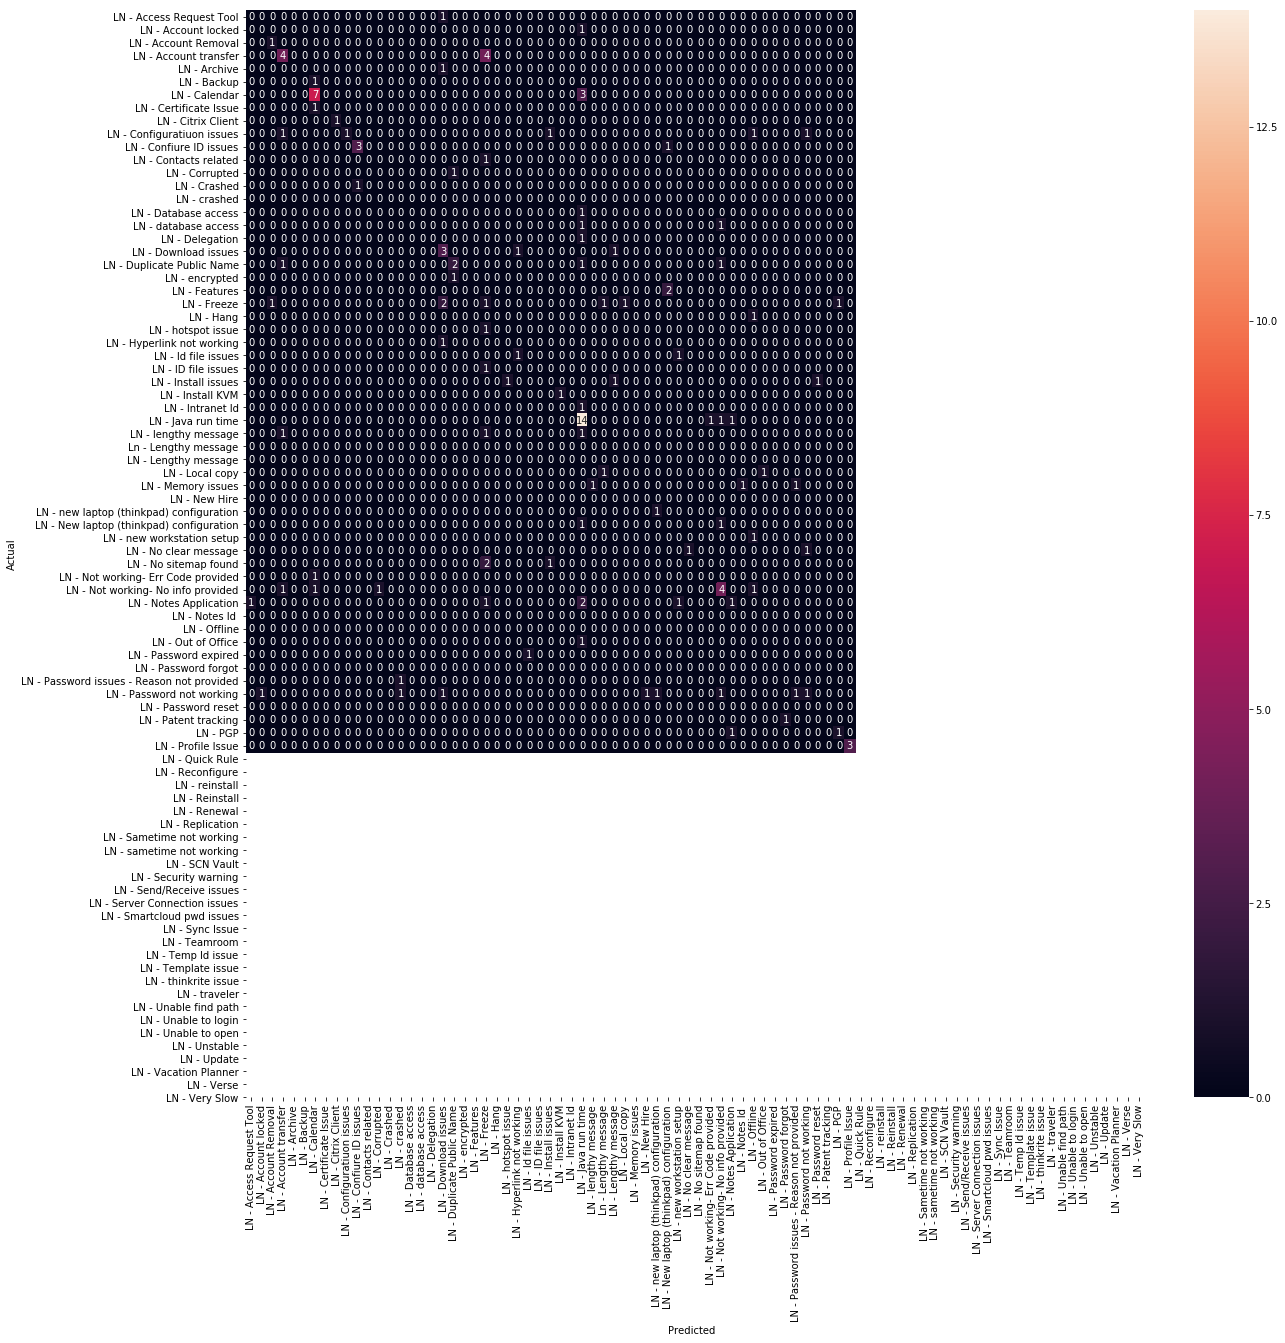

In [42]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topicid_df.topicname.values, yticklabels=topicid_df.topicname.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
print(X_test[1])
print(y_pred[1])
#for item
#y_pred = model.predict(X_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
2039


In [60]:
id_ = model.predict(tfidf.transform(["configure notes kvm window  and resolve some pop ups "]))
print(int(id_))

2010


In [61]:
id_to_category[int(id_)]

'LN - Configuratiuon issues'